In [1]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
import numpy as np
import re

# Partie 1 : Variables quantitatives

Dans cette partie, nous nous appuyons sur les données scrappées sur les 11 rankings du site YCDB. Il s'agit de variables quantitatives qui nous permettront de mettre en évidence des tendances à ressortir via des moyennes, des corrélations, des nuages de points ou encore des régressions.

### Préparation des données

In [2]:
### Ranking 1 : The Most Funded
funding = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_1.xlsx', header = 0)
### Ranking 2 : The most visited (alexaRank)
alexa_rank = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_2.xlsx', header = 0)
### Ranking 3 : The most popular (twitter followers)
twitter_followers = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_3.xlsx', header = 0)
### Ranking 4 : The Most Authoritative
domain_authority = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_4.xlsx', header = 0)
### Ranking 5 : The most liked (on facebook)
facebook_likes = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_5.xlsx', header = 0)
### Ranking 6 : The Most Upvoted
hunt_votes = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_6.xlsx', header = 0)
### Ranking 7 : The Fastest Growing
growth_score = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_7.xlsx', header = 0)
### Ranking 8 : The Most Prolific (number of statuses posted on company Twitter account)
tweet_count = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_8.xlsx', header = 0)
### Ranking 9 : The Most Influential (LinkedIn followers)
linkedin_followers = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_9.xlsx', header = 0)
### Ranking 10 : The Most populous
employees_count = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_10.xlsx', header = 0)
### Ranking 11 : The Most Cashed Out
exit_value = pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/Projet/project_python_imsd-master/ranking_11.xlsx', header = 0)

funding.head()

,noms,batch,categories,descriptions,variable
0,Airbnb,W09,Consumer,Book accommodations around the world,"$6,000.3m"
1,Cruise,W14,Transport,Self-driving cars.,"$3,368.8m"
2,Instacart,S12,Consumer,Groceries delivered fast.,"$2,095.9m"
3,Dropbox,S07,Other SaaS,Backup and share files in the cloud.,"$2,057.2m"
4,DoorDash,S13,Consumer,Restaurant delivery.,"$2,000.0m"


Il a y un peu de preprocessing à faire sur les données scrappées, comme ci-dessus avec des signes $, des m et des virgules à retirer, avant de pouvoir passer la variable en numérique.

In [3]:
### Create a list with all the ranking datasets
rankings = [funding, alexa_rank, twitter_followers, domain_authority, facebook_likes, hunt_votes, growth_score, tweet_count, linkedin_followers, employees_count, exit_value]

### Supprimer les $ et les m pour deux des rankings :
for dataset in [funding, exit_value]:
    dataset['variable'] = dataset['variable'].str[1:-1]
    
# Créer une fonction pour obtenir le nom du dataframe
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# Enlever les virgules des milliers pour les colonnes qui en ont, et 
for dataset in rankings:
    if (dataset['variable'].dtype != 'int64') & (dataset['variable'].dtype != 'float64'):
        for count, value in enumerate(dataset['variable']):
            dataset.replace(dataset['variable'][count], value.replace(',', ''), inplace=True)
    else:
        print('La variable du dataframe ' + get_df_name(dataset) + ' est déjà sous une forme adaptée.')

La variable du dataframe domain_authority est déjà sous une forme adaptée.


In [4]:
# Passer les variables d'intérêt d'objet à float.
for dataset in rankings:
    if (dataset['variable'].dtype != 'int64') & (dataset['variable'].dtype != 'float64'):
        for value in dataset['variable']:
            dataset['variable'] = dataset['variable'].astype({'variable': 'float64'})
            
# Changer le nom de la variable d'intérêt de chaque dataframe.
for dataset in rankings:
    dataset.rename(columns={'variable': get_df_name(dataset)}, inplace=True)
    
# Combiner les dataframe en un gros réunissant tout
merged_rankings = reduce(lambda  left,right: pd.merge(left,right,on=['noms', 'batch', 'categories', 'descriptions'],
                                            how='outer'), rankings)
merged_rankings.head()

,noms,batch,categories,descriptions,funding,alexa_rank,twitter_followers,domain_authority,facebook_likes,hunt_votes,growth_score,tweet_count,linkedin_followers,employees_count,exit_value
0,Airbnb,W09,Consumer,Book accommodations around the world,6000.3,234.0,695116.0,91.0,8754088.0,NaN,600.0,39485.0,NaN,6100.0,NaN
1,Cruise,W14,Transport,Self-driving cars.,3368.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1770.0,1000.0
2,Instacart,S12,Consumer,Groceries delivered fast.,2095.9,4536.0,31175.0,71.0,84839.0,NaN,NaN,40930.0,NaN,800.0,NaN
3,Dropbox,S07,Other SaaS,Backup and share files in the cloud.,2057.2,79.0,4371622.0,95.0,1351489.0,NaN,NaN,NaN,NaN,3740.0,NaN
4,DoorDash,S13,Consumer,Restaurant delivery.,2000.0,1649.0,117922.0,73.0,54532.0,NaN,930.0,NaN,NaN,1700.0,NaN


In [5]:
merged_rankings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 498
Data columns (total 15 columns):
noms                  499 non-null object
batch                 499 non-null object
categories            496 non-null object
descriptions          499 non-null object
funding               100 non-null float64
alexa_rank            100 non-null float64
twitter_followers     100 non-null float64
domain_authority      100 non-null float64
facebook_likes        100 non-null float64
hunt_votes            100 non-null float64
growth_score          100 non-null float64
tweet_count           100 non-null float64
linkedin_followers    100 non-null float64
employees_count       100 non-null float64
exit_value            73 non-null float64
dtypes: float64(11), object(4)
memory usage: 62.4+ KB


In [6]:
merged_rankings.nunique()

noms                  499
batch                  28
categories             15
descriptions          499
funding                94
alexa_rank            100
twitter_followers     100
domain_authority       32
facebook_likes        100
hunt_votes             93
growth_score           84
tweet_count           100
linkedin_followers     88
employees_count        56
exit_value             38
dtype: int64

Nos variables quantitatives sont à présent bien considérées comme des valeurs numériques. Nous avons également combiné toutes les données scrappées en un seul dataframe, comprenant désormais 499 observations. Cependant, ceci a eu pour effet de créer des NaN values lorsque l'information n'était pas disponible. L'initiative YCDB étant assez récente, les données présentes sont en effet incomplètes.

### Relation entre les variables

Nombre d'observations communes entre funding et 
alexa_rank: 38
twitter_followers: 35
domain_authority: 33
facebook_likes: 25
hunt_votes: 8
growth_score: 27
tweet_count: 32
linkedin_followers: 24
employees_count: 53
exit_value: 8


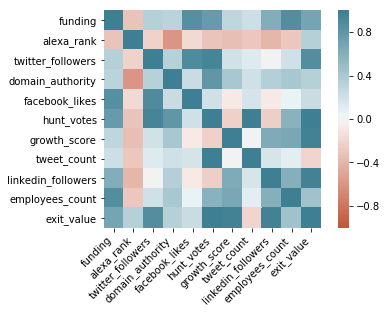

In [7]:
print('Nombre d\'observations communes entre funding et ')
for dataset in rankings[1:]:
    print(str(get_df_name(dataset)) + ': ' + str(len(merged_rankings) - sum(merged_rankings[['funding', get_df_name(dataset)]].apply(lambda x: sum(x.isnull().values), axis = 1)>0)))
    
corr = merged_rankings.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

D'abord, nous voyons en effet que les croisements entre variables conduisent à des donnée disponibles assez faibles, au maximum une cinquantaine. Cependant en dehors des variables hunt_votes (réseau social permettant de partager les nouveaux produits, très au fait du monde des start-ups) et exit_value (logique car toutes les entreprises n'ayant pas été vendues), les chiffres sont suffisants pour établir un calcul de corrélations préliminaire.

Nous voyons ainsi dans notre matrice de corrélation que la variable alexa_rank décrivant la performance et l'attrait des gens pour le site internet de la start-up est négativement corrélée avec les autres variables. Ceci est logique car plus le rang Alexa est élevée, plus vous avez un site populaire et attractif, et donc plus vous pouvez développer les autres variables (comme la capitalisation, les réseaux sociaux etc.). Par exemple, la variable domain_authority (qui décrit la tendance d'une entreprise à apparaître facilement dans des recherches Google) est négativement corrélée avec alexa_rank. Globalement, le sens des corrélation est donc cohérent avec ce que l'on peut attendre. Cependant, nombre d'entre elles sont autour de 0 au niveau de l'échelle. On peut donc suspecter des niveaux de significativité faibles.

C:\Users\moham\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\moham\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\moham\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


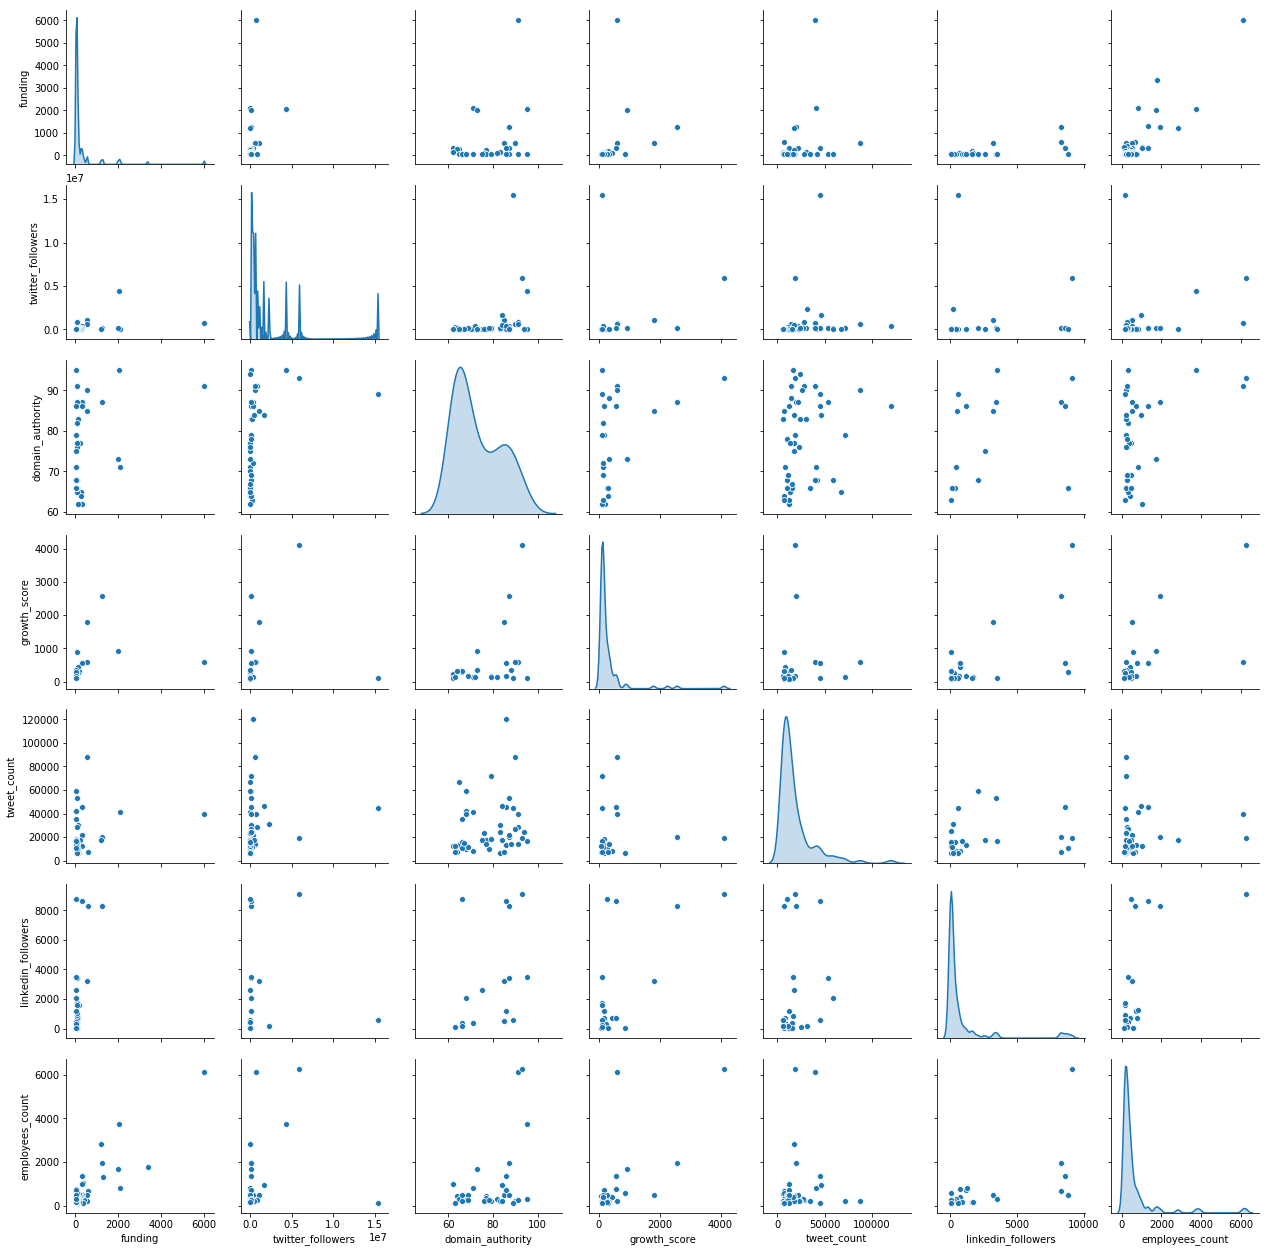

In [8]:
sns.pairplot(merged_rankings, vars=['funding', 'twitter_followers', 'domain_authority', 'growth_score', 'tweet_count', 'linkedin_followers', 'employees_count'], kind='scatter', diag_kind="kde")

Avec ces deux outils (matrice de corrélations et scatterplots), on voit des relations se confirmer. Nous allons sélectionner les relations qui nous paraissent les plus pertinentes étant données leur apparente corrélation et un nombre d'observations assez élevé, puis établir une régression. En effet, une régression a besoin d'un certain nombre d'observations pour être assez performante. Des transformations seront établies sur les variables si nécessaire, afin de mettre en évidence des relations non linéaires. Nous nous concentrerons ainsi sur les couples : funding/employees_count, funding/domain_authority, domain_authority/growth_score, growth_score/linkedin_followers, growth_score/tweet_count, linkedin_followers/employees_count, employees_count/domain_authority.

### Régressions

Coeff = [0.22930562]
R² = 0.3539149963149809


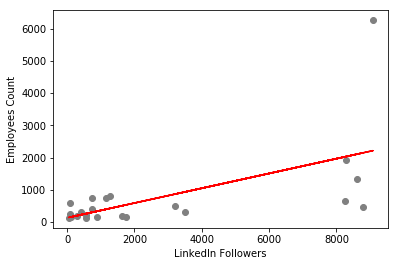

In [9]:
linkedin_employees = merged_rankings[['linkedin_followers', 'employees_count']]
linkedin_employees = linkedin_employees.dropna()

tt = TransformedTargetRegressor(regressor=LinearRegression())#,
                                #func=np.log, inverse_func=np.exp)

X = linkedin_employees.linkedin_followers.values.reshape(-1, 1)
y = linkedin_employees.employees_count.values

fitted_values = tt.fit(X, y)
linkedin_employees_pred = tt.predict(X)
linkedin_employees_R2 = tt.score(X, y)
linkedin_employees_coeff = tt.regressor_.coef_

plt.scatter(X, y, color='grey')
plt.plot(X, linkedin_employees_pred, color='red')
plt.xlabel('LinkedIn Followers')
plt.ylabel('Employees Count')
plt.show

print('Coeff = ' + str(linkedin_employees_coeff))
print('R² = ' + str(linkedin_employees_R2))

Coeff = [0.88263783]
R² = 0.7727882791175973


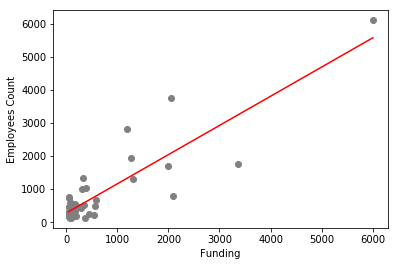

In [10]:
funding_employees = merged_rankings[['funding', 'employees_count']]
funding_employees = funding_employees.dropna()

tt = TransformedTargetRegressor(regressor=LinearRegression())#,
                                #func=np.log, inverse_func=np.exp)

X = funding_employees.funding.values.reshape(-1, 1)
y = funding_employees.employees_count.values

fitted_values = tt.fit(X, y)
funding_employees_pred = tt.predict(X)
funding_employees_R2 = tt.score(X, y)
funding_employees_coeff = tt.regressor_.coef_

plt.scatter(X, y, color='grey')
plt.plot(X, funding_employees_pred, color='red')
plt.xlabel('Funding')
plt.ylabel('Employees Count')
plt.show

print('Coeff = ' + str(funding_employees_coeff))
print('R² = ' + str(funding_employees_R2))

Coeff = [63.0199637]
R² = 0.1772903978675402


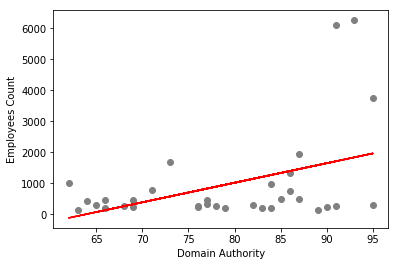

In [11]:
employees_DA = merged_rankings[['domain_authority', 'employees_count']]
employees_DA = employees_DA.dropna()

tt = TransformedTargetRegressor(regressor=LinearRegression())#,
                                #func=np.log, inverse_func=np.exp)

X = employees_DA.domain_authority.values.reshape(-1, 1)
y = employees_DA.employees_count.values

fitted_values = tt.fit(X, y)
employees_DA_pred = tt.predict(X)
employees_DA_R2 = tt.score(X, y)
employees_DA_coeff = tt.regressor_.coef_

plt.scatter(X, y, color='grey')
plt.plot(X, employees_DA_pred, color='red')
plt.xlabel('Domain Authority')
plt.ylabel('Employees Count')
plt.show

print('Coeff = ' + str(employees_DA_coeff))
print('R² = ' + str(employees_DA_R2))

Parmi les relations retenues, seulement trois ont conduit à des résultats régressifs satisfaisants. Ainsi, plus le nombre de followers linkedIn est élevé, plus le nombre d'employés est grand. Plus la capitalisation est grande, plus le nombre d'employés est grand. Et enfin, plus le score de Domain Authority est élevé, plus le nombre d'employés est élevé. 

Cependant, étant donné le faible nombre d'observations, les estimations sont peu précises. Notons qu'on obtient tout de même un coefficient de 0,88 et un R² de 0,77 pour la relations capitalisation/nombre d'employés. Ceci signifie que 100K dollars de capitalisation en plus, augmente le nombre d'employés 88. Le coefficient de détermination de 0,77 signifie que 77% de la variance du modèle est expliquée par la régression, ce qui est un bon score étant donné qu'il n'y a pas de gonflement artificiel du R² (une seule variable prise en compte). Enfin, nous avons introduit des transformations (log et exp), mais aucune ne donnait de meilleurs résultats que la régression linéaire classique.

### Analyse par promotion et par catégorie

###### Par promotion

In [12]:
print(str(len(merged_rankings.batch.unique())) + ' promotions différentes dans notre base de données.')

# Créer des listes recensant les différentes promotions et catégories
promo_list = merged_rankings.batch.unique().tolist()
promo_list = sorted(sorted(promo_list, key=lambda x : x[0], reverse=True ), key=lambda x : int(x[1:3]))

28 promotions différentes dans notre base de données.


C:\Users\moham\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Capitalisation moyenne pour une startup de la promo :
S05: 550.1M$
S06: 47.8M$
S07: 1059.0M$
W08: 390.3M$
W09: 6000.3M$
S09: 472.1M$
W10: 251.2M$
S10: 173.2M$
W11: 82.2M$
S11: 103.4M$
W12: 164.3M$
S12: 382.2M$
W13: 249.8M$
S13: 609.4M$
W14: 637.6M$
S14: 154.2M$
W15: 85.8M$
S15: 56.0M$
W16: 374.1M$
S16: 92.0M$
W17: 53.6M$
S17: 49.4M$


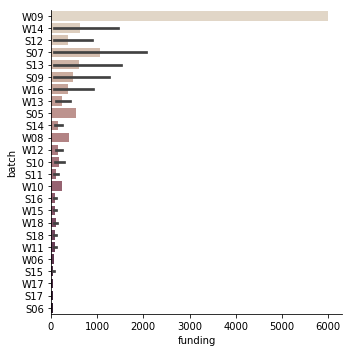

In [13]:
sns.catplot(x="funding", y="batch", palette="ch:.25", kind="bar", data=funding)

print('Capitalisation moyenne pour une startup de la promo :')
for promo in promo_list:
    if promo in str(funding.batch): 
        print(promo + ': ' + str(round(funding[funding.batch == promo].funding.mean(),1)) + 'M$')

Ce graphique nous présente la capitalisation moyenne des entreprises selon leur promotion au sein de Y combinator. La première lettre du Batch signifie la saison (Winter ou Summer), alors que les deux chiffres qui suivent correspondent à l'année. On voit que la promotion Hiver 2009 est très largement devant les autres. Ceci est dû au fait que la seule entreprise de notre base de données correspondant à cette promotion est Airbnb, qu'on n'a plus à présenter. Les barres noires nous donnent un intervalle de de fluctuation. Chaque fois qu'il y en a une, plusieurs entreprises de la promotion sont dans notre BDD.

Valeur de revente moyenne pour une startup de la promo :
S05: 14.3M$
W06: 19.5M$
S06: 124.0M$
W07: 336.0M$
S07: 22.8M$
W08: 95.0M$
S08: 3.8M$
W09: 17.6M$
S09: 4.5M$
W10: 27.3M$
S10: 34.3M$
W11: 17.5M$
S11: 46.0M$
W12: 325.0M$
S12: 1.5M$
S13: 125.2M$
W14: 1000.0M$
S14: 20.0M$
W15: 65.0M$


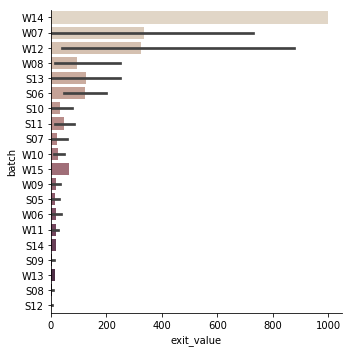

In [14]:
sns.catplot(x="exit_value", y="batch", palette="ch:.25", kind="bar", data=exit_value)

print('Valeur de revente moyenne pour une startup de la promo :')
for promo in promo_list:
    if promo in str(exit_value.batch): 
        print(promo + ': ' + str(round(exit_value[exit_value.batch == promo].exit_value.mean(),1)) + 'M$')

###### Par catégorie

In [15]:
print(str(len(merged_rankings.categories.unique())) + ' catégories d\'entreprises.')

categ_list = merged_rankings.categories.unique().tolist()

16 catégories d'entreprises.


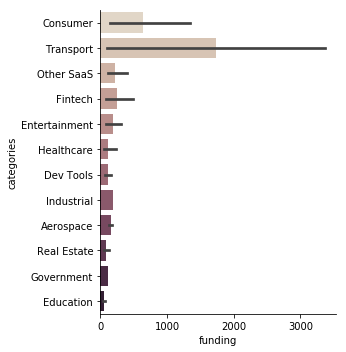

In [16]:
sns.catplot(x="funding", y="categories", palette="ch:.25", kind="bar", data=funding)

Les catégories d'entreprises avec les plus grosses capitalisations sont des entreprises de transport, ou de consommation.

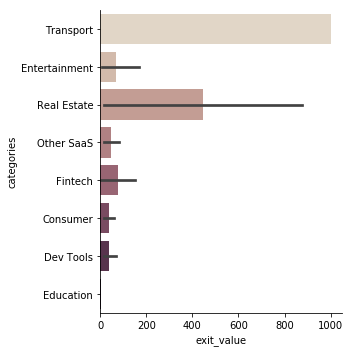

In [17]:
sns.catplot(x="exit_value", y="categories", palette="ch:.25", kind="bar", data=exit_value)

Dans la valeur de revente, on retrouve les entreprises de transport encore une fois au sommet. Cependant, la deuxième place est cette fois prise par des start-up exerçant dans l'immobilier.

# Partie 2 : Variable qualitative (Statut)

Nous avons tenu à faire une partie variables quantitatives (Partie 1) car ce type de données nous offre des possibilités d'analyse très intéressantes, allant du simple calcul de moyennes, à des matrices de corrélation, et même des approches régressives. Cependant, nous sommes conscients du fait que le nombre de données disponibles, tant en termes de lignes (nombre d'observations) qu'en termes de colonnes (présence de NaN values) limite la portée et la significativité de nos analyses.

C'est pourquoi nous nous penchons dans cette deuxième partie sur des variables purement qualitatives, nous offrant un éventail d'analyses moins large, mais un nombre de données et visualisations possibles très intéressants. Ainsi, nous avons scrappé sur le site ycdb.co les noms des entreprises, leur catégorie, leur promotion et surtout, notre nouvelle variable d'intéret : le STATUT de la start-up (en vie, morte ou vendue). Ceci nous donne donc un dataset de plus de 1700 observations.

### Préparation des données

In [18]:
batches = []
for i in range(1,29):
    batches.append(pd.read_excel('C:/Users/moham/OneDrive/Bureau/Cours/M2 IMSD/Python/batch_{}.xlsx'.format(i), header = 0))

dataset = pd.concat(batches)
dataset.reset_index(drop=True, inplace=True)
dataset.head()

,Name,Batch,Category,Description,Status
0,Airtime,S05,NaN,Airtime is a live video platform that allows p...,\n .\n Live\n ...
1,Clickfacts,S05,Other SaaS,ClickFacts is a malware software solutions com...,\n .\n Exited\n ...
2,Infogami,S05,Other SaaS,NaN,\n .\n Dead\n ...
3,Kiko,S05,Other SaaS,We're the best online calendar solution to eve...,\n .\n Exited\n ...
4,Loopt,S05,Entertainment,Loopt is a mobile application and website that...,\n .\n Exited\n ...


Il y un peu de préparation de données à faire sur cette nouvelle colonne Status.

In [19]:
for i in range(dataset.shape[0]):
    if 'Exited' in dataset.Status.iloc[i]:
        dataset.iloc[i].Status = 'Exited'
    elif 'Live' in dataset.Status.iloc[i]:
        dataset.iloc[i].Status = 'Live'
    elif 'Dead' in dataset.Status.iloc[i]:
        dataset.iloc[i].Status = 'Dead'
    else:
        print('Non expected values.')
dataset.head()

,Name,Batch,Category,Description,Status
0,Airtime,S05,NaN,Airtime is a live video platform that allows p...,Live
1,Clickfacts,S05,Other SaaS,ClickFacts is a malware software solutions com...,Exited
2,Infogami,S05,Other SaaS,NaN,Dead
3,Kiko,S05,Other SaaS,We're the best online calendar solution to eve...,Exited
4,Loopt,S05,Entertainment,Loopt is a mobile application and website that...,Exited


### Analyse

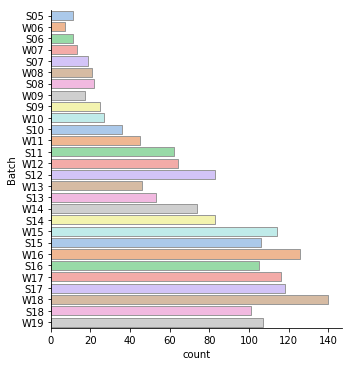

In [20]:
sns.catplot(y="Batch", kind="count",
            palette="pastel", edgecolor=".6",
            data=dataset)

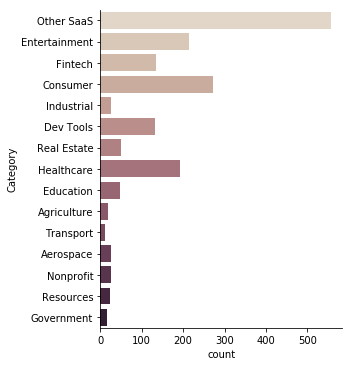

In [21]:
sns.catplot(y="Category", kind="count", palette="ch:.25", data=dataset)

On voit que les promotions sont globalement de plus en plus grandes. Concernant les catégories, les tailles sont également trèsinégales. Par exemple, la grande majorité des start-ups sont dans le domaine des SaaS, puis du divertissement, de la consommation et de la santé.  
On va donc, dans la suite, utiliser des stacked charts afin de pouvoir surpasser cette illusion du niveau, et pouvoir comparer chaque promotion de manière relative à sa taille.

###### Stacked Charts

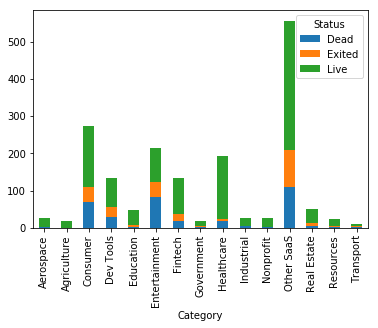

In [22]:
dataset.groupby(['Category','Status']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

Nous voyons que c'est dans le divertissement que la part d'entreprises "dead" est la plus grande, alors que la santé a la plus grande part de start-ups "Live".

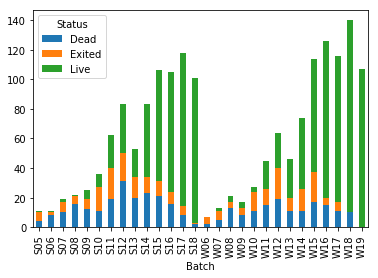

In [23]:
dataset.groupby(['Batch','Status']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

C:\Users\moham\Anaconda3\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


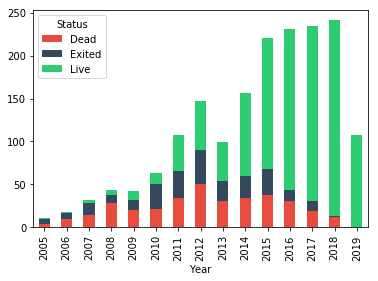

In [24]:
# Par année
year = [] 
for i in range(dataset.shape[0]):  
    year.append('20' + dataset.iloc[i].Batch[1:3])
dataset['Year'] = year

dataset.groupby(['Year','Status']).size().unstack().plot(kind='bar',stacked=True, colors = ["#e74c3c", "#34495e", "#2ecc71"])
plt.show()

Logiquement, les promotions les plus récentes ont les plus grandes parts d'entreprises "live", alors que les plus vieilles promotions ont de grosses part de "Dead" ou "Exited". C'est particulièrement le cas des promotions antérieures à 2014, pour qui plus de la moitié des start-up ne sont en pas "Live". Ceci peut signifier que la durée de vie d'une start-up atteint peu souvent les 5 ans, ou alors que les promotions les plus récentes comprennent des entreprises avec des politiques de plus long terme comparées aux entreprises pré-promotion-2014.

C:\Users\moham\Anaconda3\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


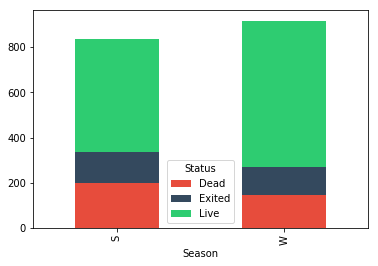

In [25]:
# Par saison
season = [] 
for i in range(dataset.shape[0]):  
    season.append(dataset.iloc[i].Batch[0])
dataset['Season'] = season

dataset.groupby(['Season','Status']).size().unstack().plot(kind='bar',stacked=True, colors = ["#e74c3c", "#34495e", "#2ecc71"])
plt.show()

Il ne semble pas que la saison de la promotion ait un impact très clair sur l'état de la start-up. La part supérieure de "live" pour les promotions d'hiver est ici due au fait que pour l'année 2019, pour laquelle la totalité des start-up sont encore en "live", nous ne disposons que des données de la promotion Winter.